In [ ]:
import os 
os.chdir("D:/project1000")
os.getcwd()


'D:\\project1000'

In [ ]:

ORIG_INPUT_DATASET = "final1000"

# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "dataset"

# define the names of the training, testing, and validation
# directories
TRAIN = "training"
TEST = "testing"

# initialize the list of class label names
CLASSES = ["brick", "carpet","ceramic","fabric","foliage","food","glass","hair","leather","metal","mirror","other","painted","paper","plastic","polishedstone","skin","sky","stone","tile","wallpaper","water","wood"]

# set the batch size
BATCH_SIZE = 32

# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
LE_PATH ='D:/project1000/output/le.cpickle'
BASE_CSV_PATH = "output"

# set the path to the serialized model after training
MODEL_PATH = 'D:/project1000/output/model.cpickle'



In [ ]:
# USAGE
# python extract_features.py

# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from pyimagesearch import config
from imutils import paths
import numpy as np
import pickle
import random
import os

# load the VGG16 network and initialize the label encoder
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)
le = None

# loop over the data splits
for split in (TRAIN, TEST):
	# grab all image paths in the current split
	print("[INFO] processing '{} split'...".format(split))
	p = os.path.sep.join([BASE_PATH, split])
	imagePaths = list(paths.list_images(p))

	# randomly shuffle the image paths and then extract the class
	# labels from the file paths
	random.shuffle(imagePaths)
	labels = [p.split(os.path.sep)[-2] for p in imagePaths]

	# if the label encoder is None, create it
	if le is None:
		le = LabelEncoder()
		le.fit(labels)

	# open the output CSV file for writing
	csvPath = os.path.sep.join([BASE_CSV_PATH,
		"{}.csv".format(split)])
	csv = open(csvPath, "w")

	# loop over the images in batches
	for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
		# extract the batch of images and labels, then initialize the
		# list of actual images that will be passed through the network
		# for feature extraction
		print("[INFO] processing batch {}/{}".format(b + 1,
			int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
		batchPaths = imagePaths[i:i + BATCH_SIZE]
		batchLabels = le.transform(labels[i:i + BATCH_SIZE])
		batchImages = []

		# loop over the images and labels in the current batch
		for imagePath in batchPaths:
			# load the input image using the Keras helper utility
			# while ensuring the image is resized to 224x224 pixels
			image = load_img(imagePath, target_size=(224, 224))
			image = img_to_array(image)

			# preprocess the image by (1) expanding the dimensions and
			# (2) subtracting the mean RGB pixel intensity from the
			# ImageNet dataset
			image = np.expand_dims(image, axis=0)
			image = imagenet_utils.preprocess_input(image)

			# add the image to the batch
			batchImages.append(image)

		# pass the images through the network and use the outputs as
		# our actual features, then reshape the features into a
		# flattened volume
		batchImages = np.vstack(batchImages)
		features = model.predict(batchImages, batch_size=BATCH_SIZE)
		features = features.reshape((features.shape[0], 7 * 7 * 512))

		# loop over the class labels and extracted features
		for (label, vec) in zip(batchLabels, features):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			csv.write("{},{}\n".format(label, vec))

	# close the CSV file
	csv.close()

# serialize the label encoder to disk
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()

plot_model(model, to_file='base_model_plot.png', show_shapes=True, show_layer_names=True)



In [ ]:
#RANDOM FOREST
# USAGE
# python train.py

# import the necessary packages
#from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
#from pyimagesearch import config
import numpy as np
import pandas as pd
import pickle
import os

def load_data_split(splitPath):
	# initialize the data and labels
	data = []
	labels = []

	# loop over the rows in the data split file
	for row in open(splitPath):
		# extract the class label and features from the row
		row = row.strip().split(",")
		label = row[0]
		features = np.array(row[1:], dtype="float")

		# update the data and label lists
		data.append(features)
		labels.append(label)

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)
	labels=labels.astype(str)
	

	# return a tuple of the data and labels
	return (data, labels)

# derive the paths to the training and testing CSV files
trainingPath='D:/project1000/output/training.csv'
testingPath='D:/project1000/output/testing.csv'

CLASSES = ["brick", "carpet","ceramic","fabric","foliage","food","glass","hair","leather","metal","mirror","other","painted","paper","plastic","polishedstone","skin","sky","stone","tile","wallpaper","water","wood"]


# load the data from disk
print("[INFO] loading data...")
(trainX, trainY) = load_data_split(trainingPath)
(testX, testY) = load_data_split(testingPath)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


pickle_out=open("trainX.pickle","wb")
pickle.dump(trainX,pickle_out)
pickle_out.close()

pickle_out=open("trainY.pickle","wb")
pickle.dump(trainY,pickle_out)
pickle_out.close()

pickle_out=open("testX.pickle","wb")
pickle.dump(testX,pickle_out)
pickle_out.close()

pickle_out=open("testY.pickle","wb")
pickle.dump(testY,pickle_out)
pickle_out.close()


pickle_in=open("trainX.pickle","rb")
trainX=pickle.load(pickle_in)

pickle_in=open("trainY.pickle","rb")
trainY=pickle.load(pickle_in)

pickle_in=open("testX.pickle","rb")
testX=pickle.load(pickle_in)

pickle_in=open("testY.pickle","rb")
testY=pickle.load(pickle_in)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

# load the label encoder from disk
le = pickle.loads(open("D:/project1000/output/le.cpickle", "rb").read())

rf = RandomForestClassifier()

rf.fit(trainX,trainY)
# Predictions on training and validation
y_pred_train = rf.predict(trainX)

    # training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true=trainY, y_pred= y_pred_train,target_names=CLASSES))

# Predictions on testset
y_pred_test = rf.predict(testX)
    # test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= testY, y_pred= y_pred_test,target_names=CLASSES))


# serialize the model to disk
print("[INFO] saving model...")
f = open("D:/project1000/output/model.cpickle", "wb")
f.write(pickle.dumps(model))
f.close()

print('Model Accuracy: {Random Forest.score(testX, testY)}',rf.score(testX, testY))


print("=== Confusion Matrix ===")
print(confusion_matrix(testY, y_pred_test))
print('\n')


import pickle

Model_file = 'RF_model_100_8020.pkl'

pickle.dump(rf, open(Model_file, 'wb'))


###

[INFO] loading data...
(18400, 25088)
(18400,)
(4600, 25088)
(4600,)
(18400, 25088)
(18400,)
(4600, 25088)
(4600,)


C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training metrics:
               precision    recall  f1-score   support

        brick       1.00      1.00      1.00       800
       carpet       0.99      1.00      1.00       800
      ceramic       1.00      1.00      1.00       800
       fabric       1.00      1.00      1.00       800
      foliage       0.99      1.00      1.00       800
         food       1.00      1.00      1.00       800
        glass       1.00      1.00      1.00       800
         hair       1.00      1.00      1.00       800
      leather       0.99      1.00      0.99       800
        metal       0.99      1.00      1.00       800
       mirror       1.00      1.00      1.00       800
        other       1.00      0.99      1.00       800
      painted       1.00      1.00      1.00       800
        paper       1.00      1.00      1.00       800
      plastic       1.00      1.00      1.00       800
polishedstone       1.00      0.99      0.99       800
         skin       1.00      1.00      1.00  

NameError: name 'model' is not defined

In [ ]:
#SVM


# USAGE
# python train.py

# import the necessary packages
#from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
#from pyimagesearch import config
import numpy as np
import pandas as pd
import pickle
import os

# derive the paths to the training and testing CSV files
trainingPath='D:/project1000/output/training.csv'
testingPath='D:/project1000/output/testing.csv'

CLASSES = ["brick", "carpet","ceramic","fabric","foliage","food","glass","hair","leather","metal","mirror","other","painted","paper","plastic","polishedstone","skin","sky","stone","tile","wallpaper","water","wood"]

pickle_in=open("trainX.pickle","rb")
trainX=pickle.load(pickle_in)

pickle_in=open("trainY.pickle","rb")
trainY=pickle.load(pickle_in)

pickle_in=open("testX.pickle","rb")
testX=pickle.load(pickle_in)

pickle_in=open("testY.pickle","rb")
testY=pickle.load(pickle_in)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


# load the label encoder from disk
le = pickle.loads(open("D:/project1000/output/le.cpickle", "rb").read())

model = LinearSVC(C=100.0, random_state=42)
model.fit(trainX, trainY)

import sklearn
from sklearn.metrics import classification_report

CLASSES = ["brick", "carpet","ceramic","fabric","foliage","food","glass","hair","leather","metal","mirror","other","painted","paper","plastic","polishedstone","skin","sky","stone","tile","wallpaper","water","wood"]

y_pred_train = model.predict(trainX)
    # predictions for test
    # training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true=trainY, y_pred= y_pred_train,target_names=CLASSES))
    
# Predictions on testset
y_pred_test = model.predict(testX)
    # test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= testY, y_pred= y_pred_test,target_names=CLASSES))

print('Model Accuracy: {svm.score(testX, testY)}',model.score(testX, testY))

print("=== Confusion Matrix ===")
print(confusion_matrix(testY, y_pred_test))
print('\n')

import pickle

Model_file = 'SVM_model_500_8020.pkl'

pickle.dump(model, open(Model_file, 'wb'))


####

(18400, 25088)
(18400,)
(4600, 25088)
(4600,)
Training metrics:
               precision    recall  f1-score   support

        brick       1.00      1.00      1.00       800
       carpet       1.00      1.00      1.00       800
      ceramic       1.00      1.00      1.00       800
       fabric       1.00      1.00      1.00       800
      foliage       1.00      1.00      1.00       800
         food       1.00      1.00      1.00       800
        glass       1.00      1.00      1.00       800
         hair       1.00      1.00      1.00       800
      leather       1.00      1.00      1.00       800
        metal       1.00      1.00      1.00       800
       mirror       1.00      1.00      1.00       800
        other       1.00      1.00      1.00       800
      painted       1.00      1.00      1.00       800
        paper       1.00      1.00      1.00       800
      plastic       1.00      1.00      1.00       800
polishedstone       1.00      1.00      1.00       800


In [ ]:
#LOGISTIC

# import the necessary packages
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
#from pyimagesearch import config
import numpy as np
import pandas as pd
import pickle
import os

# derive the paths to the training and testing CSV files
trainingPath='D:/project1000/output/training.csv'
testingPath='D:/project1000/output/testing.csv'

CLASSES = ["brick", "carpet","ceramic","fabric","foliage","food","glass","hair","leather","metal","mirror","other","painted","paper","plastic","polishedstone","skin","sky","stone","tile","wallpaper","water","wood"]

pickle_in=open("trainX.pickle","rb")
trainX=pickle.load(pickle_in)

pickle_in=open("trainY.pickle","rb")
trainY=pickle.load(pickle_in)

pickle_in=open("testX.pickle","rb")
testX=pickle.load(pickle_in)

pickle_in=open("testY.pickle","rb")
testY=pickle.load(pickle_in)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


# load the label encoder from disk
le = pickle.loads(open("D:/project1000/output/le.cpickle", "rb").read())

lmodel = LogisticRegression(solver="lbfgs", multi_class="auto")
lmodel.fit(trainX, trainY)
preds = lmodel.predict(testX)
print(classification_report(testY, preds, target_names=le.classes_))
print('Model Accuracy: {logistic.score(testX, testY)}',lmodel.score(testX, testY))

print('\n')

print("=== Confusion Matrix ===")
print(confusion_matrix(testY, preds))
print('\n')


###

(18400, 25088)
(18400,)
(4600, 25088)
(4600,)


C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


               precision    recall  f1-score   support

        brick       0.63      0.61      0.62       200
       carpet       0.65      0.75      0.70       200
      ceramic       0.62      0.62      0.62       200
       fabric       0.76      0.69      0.72       200
      foliage       0.62      0.68      0.65       200
         food       0.70      0.72      0.71       200
        glass       0.53      0.52      0.53       200
         hair       0.62      0.61      0.61       200
      leather       0.78      0.78      0.78       200
        metal       0.90      0.94      0.92       200
       mirror       0.67      0.68      0.68       200
        other       0.56      0.56      0.56       200
      painted       0.56      0.59      0.58       200
        paper       0.70      0.72      0.71       200
      plastic       0.88      0.85      0.87       200
polishedstone       0.57      0.57      0.57       200
         skin       0.60      0.53      0.56       200
         

In [ ]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
#url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = pandas.read_csv(url, names=names)
#array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
#model1 = LogisticRegression()
estimators.append(('logistic', lmodel))
#model2 = DecisionTreeClassifier()
#estimators.append(('rf', rf))
#model3 = SVC()
estimators.append(('svm', model))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, testX, testY, cv=kfold)
print(results.mean())


###

ensemble.fit(trainX,trainY)

CLASSES = ["brick", "carpet","ceramic","fabric","foliage","food","glass","hair","leather","metal","mirror","other","painted","paper","plastic","polishedstone","skin","sky","stone","tile","wallpaper","water","wood"]

y_pred_train = ensemble.predict(trainX)
    # predictions for test
    # training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true=trainY, y_pred= y_pred_train,target_names=CLASSES))
    
# Predictions on testset
y_pred_test = ensemble.predict(testX)
    # test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= testY, y_pred= y_pred_test,target_names=CLASSES))

print("=== Confusion Matrix ===")
print(confusion_matrix(testY, y_pred_test))
print('\n')

print('Model Accuracy: {ensemble.score(testX, testY)}',ensemble.score(testX, testY))



C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.6141304347826086


C:\Users\RDK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training metrics:
               precision    recall  f1-score   support

        brick       1.00      1.00      1.00       800
       carpet       1.00      1.00      1.00       800
      ceramic       1.00      1.00      1.00       800
       fabric       1.00      1.00      1.00       800
      foliage       1.00      1.00      1.00       800
         food       1.00      1.00      1.00       800
        glass       1.00      1.00      1.00       800
         hair       1.00      1.00      1.00       800
      leather       1.00      1.00      1.00       800
        metal       1.00      1.00      1.00       800
       mirror       1.00      1.00      1.00       800
        other       1.00      1.00      1.00       800
      painted       1.00      1.00      1.00       800
        paper       1.00      1.00      1.00       800
      plastic       1.00      1.00      1.00       800
polishedstone       1.00      1.00      1.00       800
         skin       1.00      1.00      1.00  

In [ ]:
from matplotlib import pyplot as plt
import cv2

Using TensorFlow backend.


[[ 0.         38.74722672  0.         ...  0.13690701  0.
   0.        ]]
skin


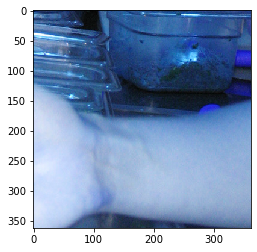

In [ ]:
################################3
##Image testing code starts here#######
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import cv2
#from pyimagesearch import config
from imutils import paths
import numpy as np
import pickle
import random
import os

model = VGG16(weights="imagenet", include_top=False)
img_path = 'D:/project1000/final1000/training/skin_000095.jpg'
img = cv2.imread(img_path)
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
# preprocess the image by (1) expanding the dimensions and
# (2) subtracting the mean RGB pixel intensity from the
# ImageNet dataset
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
features = model.predict(image)
features = features.reshape((features.shape[0], 7 * 7 * 512))
data = np.array(features,dtype="float")
print(data)
labelValue = ensemble.predict(data);
plt.imshow(img)
print(CLASSES[int(labelValue[0])])
#MAPPING = dict({0:"brick", 1:"carpet",2:"ceramic",3:"fabric",4:"foliage",5:"food",6:"glass",7:"hair",8:"leather",9:"metal",10:"mirror",11:"other",12:"painted",13:"paper",14:"plastic",15:"polishedstone",16:"skin",17:"sky",18:"stone",19:"tile",20:"wallpaper",21:"water":21,"wood":22})
########################################

[[0.         0.         0.         ... 0.         1.05498791 0.        ]]
skin


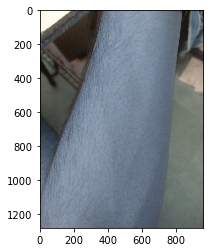

In [ ]:

img_path = 'D:/project1000/final1000/testSamples/skin.jpg'
img = cv2.imread(img_path)
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
# preprocess the image by (1) expanding the dimensions and
# (2) subtracting the mean RGB pixel intensity from the
# ImageNet dataset
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
features = model.predict(image)
features = features.reshape((features.shape[0], 7 * 7 * 512))
data = np.array(features,dtype="float")
print(data)
labelValue = ensemble.predict(data);
plt.imshow(img)
print(CLASSES[int(labelValue[0])])